In [27]:
!pip install --quiet scikit-learn torchsummary

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

data_path = 'data'

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
# Load the best model
best_model = models.resnet18()
best_model.fc = nn.Linear(best_model.fc.in_features, 2)
best_model.load_state_dict(torch.load('best_transfer_learning_model.pth'))
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Convert labels and predictions to numpy arrays
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

In [39]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate and print various metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 99.25%
Precision: 0.9953
Recall: 0.9906
F1 Score: 0.9930

Confusion Matrix:
[[371   2]
 [  4 423]]


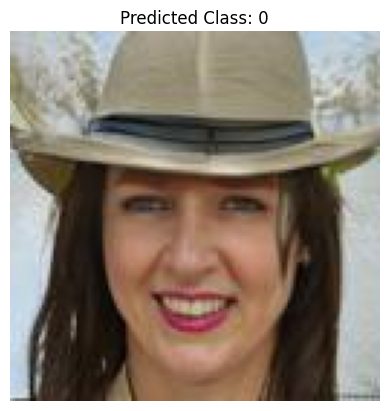

In [40]:
image_path = "data/fake/f292.jpg"

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image = Image.open(image_path).convert("RGB")
input_image = image_transform(image).unsqueeze(0) 

best_model.eval()

with torch.no_grad():
    output = best_model(input_image)
    _, predicted = torch.max(output, 1)

plt.imshow(image)
plt.title(f"Predicted Class: {predicted.item()}")
plt.axis('off')
plt.show()